# How to Initialize HPSim Beam
In this document, we will demonstrate two ways to create a beam object for an HPSim Beam simulation. The beam object is one of the inputs that are supplied by the user. 
There are basically two ways to create a beam object. The first is to use the Python API, e.g. `set_dc` that will create a DC beam distribution for use in that simulation. (You could use the API `set_waterbag`, but this would require addition longitudinal beam information that cannot be measured presently at LANSCE.) The second way is to use an existing beam distribution previously created by HPSim and stored in a file by using the Python API `set_distribution`. This is more beneficial for use with a generic distribution that is not a DC beam. Refer to the HPSim manual for details on these API's.
* Create DC beam using Twiss paramters from emittance scan, e.g. TBEM01
* Print out beam particle data to a file for later reuse
* Use previously generated beam stored in a file

Once you have created the beam distribution in your script, you will also need to add a space-charge class to correctly model the repulsion of the like-charged ions and then a simulator object to enable the beam to be simulation in a portion of the accelerator.
* Set up Space Charge for your simulation
* Create a simulator class for the simulation


### Create DC beam using Twiss paramters from emittance scan, e.g. TBEM01
For the first example, TBEM01, one needs to have the horizontal(X) and vertical(Y) Twiss parameters. These Twiss parameters (alpha, beta, emittance_total_unnormalized) are extracted from analysis of the emittance measurements made at LANSCE. At the TBEM01 emittance station, which is located near the beginning of transport TB, immediately after the H- beam is accelerated to 750 keV, the beam within a macropulse is DC so one only needs the transverse Twiss parameters. We we will use data from this station to create the DC beam distribution using the API `set_dc`. For the Twiss parameters I will use the results from the EMRP analysis of EM data runs, 30599(H) and 30600(V)
![EM 30599](figures/em_TBEM1_H_30599.png) 
![EM 30600](figures/em_TBEM1_V_30600.png).

However, these values need to be put into the correct units. For emittance output LANSCE uses cm and mr. For `set_dc`, HPSim uses cm and rad, and deg and MeV. **N.B.** There is a multiplicative factor of six that is need to convert the transverse emittances from rms to total. The generated distribution will be a 4-D transverse hyperspace with uniform phase spread and no energy spread. (This is a good approximation for the CW beam which only has a few to several hunderd keV of energy variation out of 750 keV.) The values from the EMRP outputs and the converts values for use in HPSim:

| Quantity |  LANSCE  |      HPSim |
|----------|----------|------------|
| alpha_x  | 0.411    |    0.411   |
| beta_x   | 0.231    |   231.0    |
| 6*erms_x | 2.832    | 0.002832   |

| Quantity |  LANSCE  |      HPSim |
|----------|----------|------------|
| alpha_y  | -1.211   |   -1.211   |
| beta_y   | 0.215    |   215.0    |
| 6*erms_y | 3.006    | 0.003006   |

For the `set_dc` beam, we also need to define the longitudinal piece of the distribution. Since it is DC, it should be monoenergtic with a phase spread around the synchronous phase of +-180 deg. (These are 201 MHz degrees.)

| Quantity  |    HPSim                |
|-----------|-------------------------|
| delta_phi | 180.0                   |  
| synch_phi | 0.0                     |  
| synch_W   | 0.750 + ENERGY_OFFSET   |  

`ENERGY_OFFSET` is a constant defined in the HPSim python code to change the energy of the initial beam to reflect a more accurate estimate of the beam from the nominal energy of 750 keV. **N.B.** The output of each Cockcroft-Walton injectors is nominally a 750 keV beam. However, comparison of a H+ and H- Tank 1 PS201 scans with the resepective prebunchers delayed shows a difference in the location of the phase scan distributions, which appears because the particle masses are different and the beam energies may be different. Therefore, the assumption was that the H+ CW energy gain was at 750 keV and the H- CW energy gain was at (750 keV + `ENERGY_OFFSET` to account for this difference. **N.B.** The H- beam is first accelerated to 80 keV in the CW dome, then given an additional 670 keV of energy gain in the TBCW for a total of 750 keV. In the past a value of 0.0016 or 0.0006 have been used. A comparison should the H+ and H- T1 w/pB-delayed scans should be done to assess this difference and select the appropriate value for the simulation.

Using the above HPSim values, we create the TBEM01 beam distribution with the following line of code. The reference point of this beam is at the TBEM01 slit.

`set_dc( 0.411, 231.0, 0.002832, -1.211, 215.0, 0.003006, 180.0, 0.0, 0.750 + ENERGY_OFFSET)`



 

### HPSim code script
There are several sections required in every HPSim Python script. We will not use all of them in this tutorial, but only those upto where the beam is created.
**Section one is where we define paths and import the required Python modules**

In [1]:
# initial section to import python modules required for simulations
import sys
import os
# define directory to packages and append to $PATH

par_dir = os.path.abspath(os.path.pardir)
print(par_dir)
pkg_dir = os.path.join(par_dir,"pylib")
print(pkg_dir)
sys.path.append(pkg_dir)

#import additional python packages
import numpy as np
import matplotlib.pyplot as plt
# import additional simulation packages
import hpsim as hps # hpsim provides access to the Python APIs used most often
#import HPSim as HPS # HPSim provides access to some addition lower-level functionality
from hpsim import sqldb as pydb
from hpsim import lcsutil as lcs
from hpsim import nputil as npu
GPU = 0
hps.set_gpu(GPU)

/home/echuang/hpsim
/home/echuang/hpsim/pylib
GPU : NVIDIA RTX A6000


**Section two is where we connect to the databases that have all the beamline component information.**
In this case we are just importing the low-energy beam transports TB & TD as tbtd.db. The tbtd.db file must exist in your hpsim/db directory and are the SQL database files that hold the respective beam line components and layout.

In [3]:
################################################################################
# install db's and connect to beamline
db_dir = par_dir + '/db'
lib_dir = par_dir + '/db/lib'
dbs = ['tbtd.db','dtl.db']
dbconn1 = hps.DBConnection(db_dir, dbs, lib_dir, 'libsqliteext.so')
dbconn1.print_dbs()
dbconn1.clear_model_index()
print("*** dB connection established ***")

main -> /home/echuang/hpsim/db/tmp/tbtd.db
db1 -> /home/echuang/hpsim/db/tmp/dtl.db
*** dB connection established ***


**Section three is where we create a beamline object.**

In [4]:
################################################################################
# create beamline
bl = hps.BeamLine()
beamline = hps.get_element_list()
print("*** Beamline created ***")

*** Beamline created ***


**Section four is where we create the beam object**

*Please refer to the HPSim User Guide for details about the API arguments*

`beam = hps.Beam` is required to create the beam object for the H- beam with the correct mass in MeV/c^2, charge, current in Amps and number of particles in the initial beam bunch.

`beam.set_dc` creates the initial beam distribution from the supplied Twiss parameters and additional information provided for the longitudinal phase space.

The next lines of code define the initial beam frequency, e.g. 201.25 MHz for the bunchers and DTL. One also has to define the reference particle energy and phase. Please read the comments in the text below for information on the few extra lines of code.

In [5]:
################################################################################
# create H- beam
SIM_START = "TBEM01" #defined by input beam location
NOMINAL_W = 0.750
ENERGY_OFFSET = 0.0001
SYNCH_W = NOMINAL_W + ENERGY_OFFSET
NPART = 1024*64
beam = hps.Beam(mass=939.294, charge=-1.0, current=0.015, num=NPART) # H- beam
beam.set_dc( 0.411, 231.0, 0.002832, -1.211, 215.0, 0.003006, 180.0, 0.0, SYNCH_W) # TBEM01 #30599, 30600
beam.set_frequency(201.25)
# the next two lines of code are used to calculate the phase offset between Butt Line Zero (BLZ), which we 
# treat as a reference point with phase = 0 for the reference particle. We set the reference particle energy 
# to 0.750 MeV and its shift its phase accordingly.
betalambda = hps.betalambda(mass = beam.get_mass(), freq=beam.get_frequency(), w=SYNCH_W)
phi_offset = -hps.get_beamline_length(SIM_START,'BLZ')/betalambda *360
beam.set_ref_w(NOMINAL_W)
beam.set_ref_phi(phi_offset)
# Finally, we shift the phase of all particles in the distribution by the phi_offset amount. This scheme 
# would allow us to create a transverse beam at a different location but arrive at BLZ with the same phase.
beam.translate('phi', phi_offset)
beam.save_initial_beam()
print('*** ', SYNCH_W, ' MeV H- Beam created at', SIM_START, ' with ', NPART, 'particles ***')

***  0.7501  MeV H- Beam created at TBEM01  with  65536 particles ***
Beam frequency initialized to 201.25


At this point we have have created the input beam distribution and saved it internally for recall later if needed.
Here are an analysis and a plot of that input beam distribution. The unnormalize rms emittances should agree with the EMRP output when corrected for units.

*** Output Beam ***
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 15.00 mA
Frequency = 201.250 MHz
*** Mask applied ***
Number of macroparticles(mask) = 65536
Number of macroparticles lost  = 0
Ref part. 
 phi = -68955.7995 deg
   w =     0.7500 MeV

Centroids and RMS sizes
            Avg         Sigma
x  :      -0.0014        0.3294 cm 
xp :       0.0072        1.5527 mr 
y  :       0.0009        0.3277 cm 
yp :       0.0033        2.3868 mr 
phi:  -68955.7940      103.9207 deg
w  :       0.7501        0.0000 MeV

Twiss parameters
          Alpha       Beta       Eurms       Enrms
x :      0.4087      0.2292      0.4735     0.01893
y :     -1.2024      0.2147      0.5001     0.01999
z :     -0.0000 266038944.5176      0.0000


 4 x  3 BeamPlot object created
[-0.7990116415184394, 0.7979782156201697] [-3.7398901963650704, 3.716384299385191]
[-0.7979555546493292, 0.7984171109290963] [-5.775190848344653, 5.839957706384279]


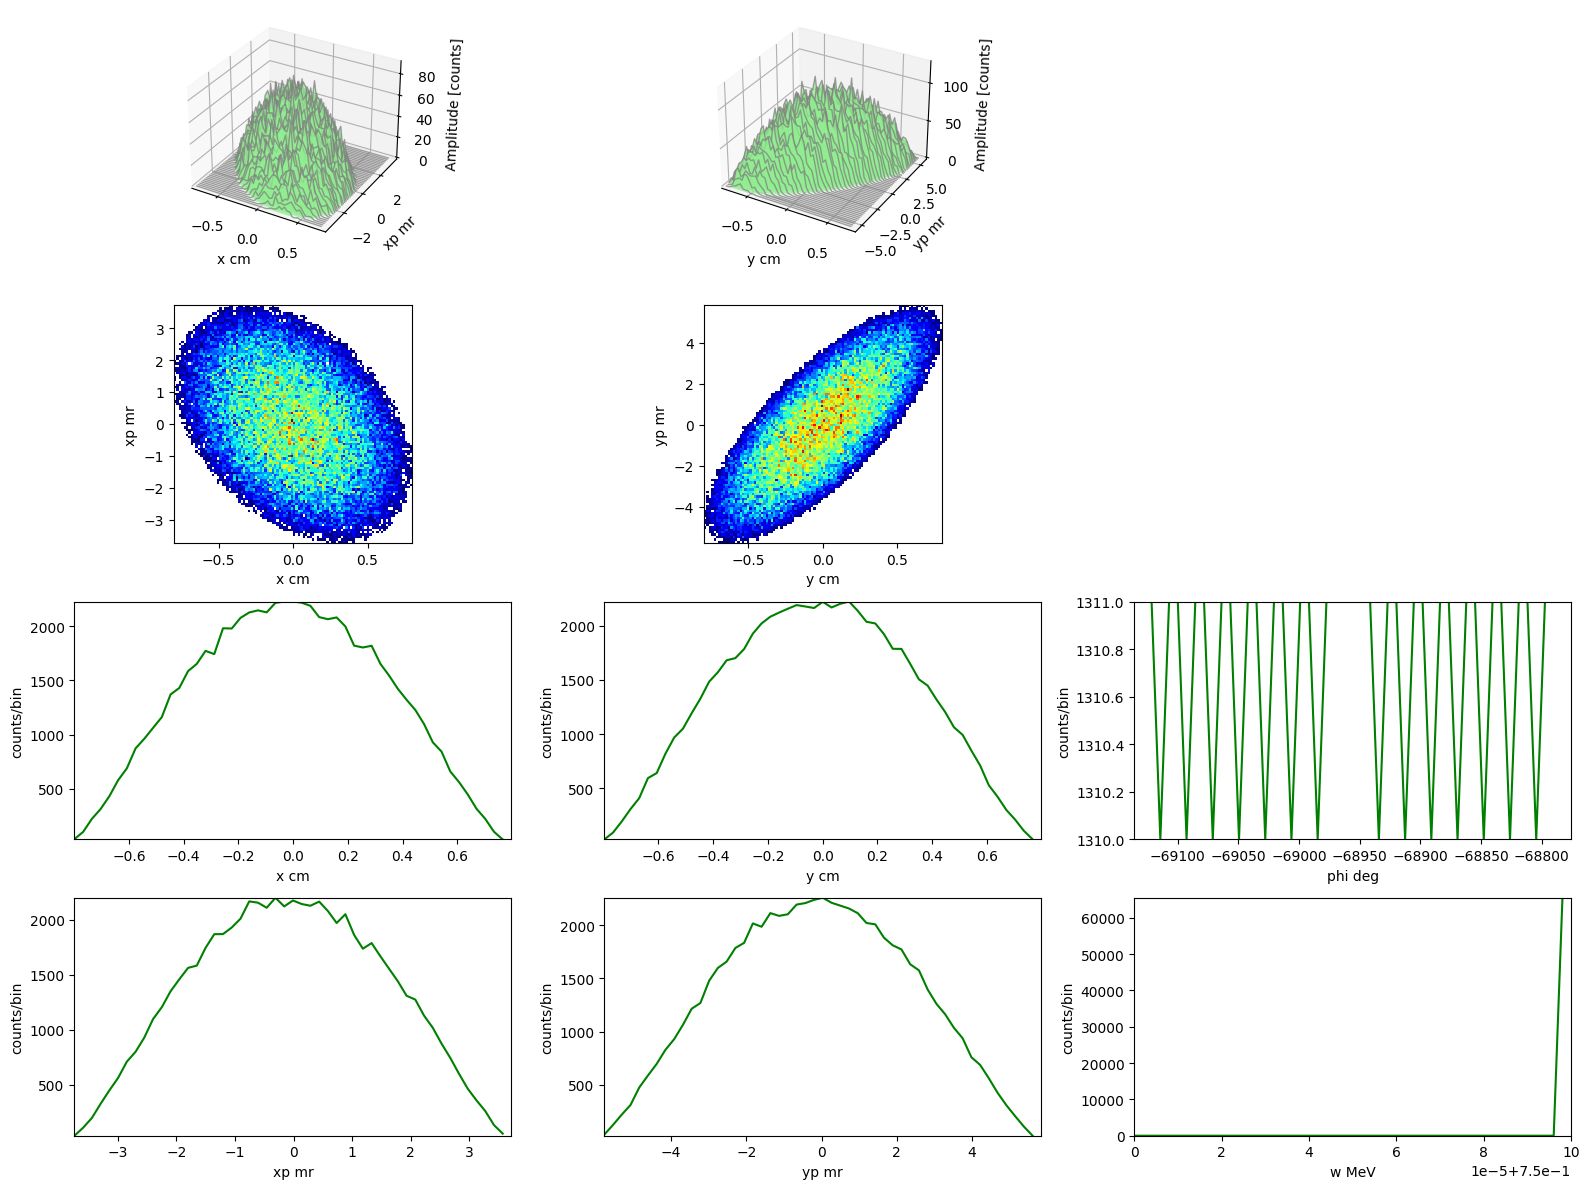

In [6]:
#create mask to analyze and plot all "good" particles, which should be all of them at this point
mask = beam.get_good_mask()

# analyze beam and print results
print('*** Output Beam ***')
print('w/user units')
beam.print_results(mask)

# create output plot
plot = hps.BeamPlot(nrow=4, ncol=3, hsize=16, vsize=12)
plot.title(SIM_START)
plot.iso_phase_space('xxp', beam, mask, 1)
plot.iso_phase_space('yyp', beam, mask, 2)

plot.hist2d_phase_space('xxp', beam, mask, 4)
plot.hist2d_phase_space('yyp', beam, mask, 5)

plot.profile('x', beam, mask, 7, 'g-')
plot.profile('y', beam, mask, 8, 'g-')
plot.profile('phi', beam, mask, 9, 'g-')

plot.profile('xp', beam, mask, 10, 'g-')
plot.profile('yp', beam, mask, 11, 'g-')
plot.profile('w', beam, mask, 12, 'g-',ylog=False)

plot.show()

## get the beam info
One can directly get the particle information as a pandas dataframe like below:

In [7]:
dfbeam = beam.data
print(dfbeam.head())

          x        xp         y        yp           phi       w  lost_idx  \
0  0.000000  0.000000  0.000000  0.000000 -68955.799497  0.7500         0   
1 -0.596346  2.006773 -0.361088 -3.073061 -69135.788510  0.7501         0   
2 -0.213715 -0.669606 -0.164051  1.939455 -69135.783017  0.7501         0   
3 -0.295399 -0.694573  0.511800  3.718842 -69135.777524  0.7501         0   
4 -0.382826 -0.532672 -0.445398 -2.574376 -69135.772031  0.7501         0   

        phi_r  
0    0.000000  
1 -179.989014  
2 -179.983521  
3 -179.978027  
4 -179.972534  


### Print out beam particle data to a file for later reuse
At this point, you have created an input beam distribution for use in the simulation. If you begin your HPSim Python script with the above Python code, you will create a new distribution each time you run the code. However, if you would like to start with the same distribution, you can save the above beam distribution to a file for later use. To do this you would add the following code.

In [8]:
# code to print all beam coordinates to a file for later use
beam.print_to("TBEM01-30599-30600.txt")

Using the `head` command, we see the first 10 lines of the beam file

In [10]:
!head TBEM01-30599-30600.txt

Info 
Charge  -1
Mass 939.294
Current 0.015
Frequency 201.25
0  0  0  0  -1203.50573955899  0.75  0  0
-0.00596345541135619  0.0020067725174716  -0.00361088175825981  -0.00307306112697705  -1206.64714046498  0.7501  0  0
-0.00213715312310916  -0.000669605725512788  -0.00164050980638478  0.00193945546185785  -1206.64704459118  0.7501  0  0
-0.00295399038053112  -0.000694573266776612  0.00511799770466769  0.0037188415523552  -1206.64694871738  0.7501  0  0
-0.00382826338977342  -0.000532671511317028  -0.00445398388931489  -0.0025743762572178  -1206.64685284358  0.7501  0  0


### Use previously generated beam stored in a file
Once you have created this file containing an input distribution at TBEM01, you can replace the beam create code in cell [4] above with the following code.

In [11]:
################################################################################
# create H- beam
# Create beam object from existing file of particle coordinates.
SIM_START = "TBEM01" #defined by input beam location
beam = hps.Beam(file = "TBEM01-30599-30600.txt")

Beam is freed. 


One can check the beam is loaded into memory by printing results. 

In [12]:
#create mask to analyze and plot all "good" particles, which should be all of them at this point
mask = beam.get_good_mask()

# analyze beam and print results
print('*** Output Beam ***')
print('w/user units')
beam.print_results(mask)

*** Output Beam ***
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 15.00 mA
Frequency = 201.250 MHz
*** Mask applied ***
Number of macroparticles(mask) = 65536
Number of macroparticles lost  = 0
Ref part. 
 phi = -68955.7995 deg
   w =     0.7500 MeV

Centroids and RMS sizes
            Avg         Sigma
x  :      -0.0014        0.3294 cm 
xp :       0.0072        1.5527 mr 
y  :       0.0009        0.3277 cm 
yp :       0.0033        2.3868 mr 
phi:  -68955.7940      103.9207 deg
w  :       0.7501        0.0000 MeV

Twiss parameters
          Alpha       Beta       Eurms       Enrms
x :      0.4087      0.2292      0.4735     0.01893
y :     -1.2024      0.2147      0.5001     0.01999
z :     -0.0000 266038944.5176      0.0000




### Set up Space Charge for your simulation

The mutual repulsion of H- ions in the beam must be included in the model to accurately simulate the evolution of the beam along the transports and accelerator. The model of space charge used in HPSim was taken from the PARMILA code developed at LANL [LA-UR-98-4478]. In this model and for the purpose of applying space charge kicks to the individual beam particles, the beam is placed ion a mesh which is divided radially and longitudinally as rings of charge, which is therefore cylindrically symmetric. For this to be effective, one needs to define a mesh size that covers the whole beam and is divided into enough 'slices' to provide the variation in the forces consistent with the beam shape. (Please refer to X. Pang & L. Rybarcyk, "GPU accelerated online multiparticle beam dynamics simulator for ion linear particle accelerators", LA-UR-13-23560, for details about the routine.) 

**Section 5 is where we create a space-charge class for the simulation.**

In this section ones has to define the space charge mesh using `nr` and `nz` for the number of mesh slices in the radial and longitudinal direction, respectively. (Values that are powers of 2 are beneficial). The `interval` is the maximum spacing between space charge kicks. So a value of 0.025 says you will have a space-charge kick every 2.5 cm or less in a drift space. To mimic the appropriate longitudinal boundary conditions, one needs to specify the number of adjacent bunches, `adj_bunch`, on either side of the beam bunch being simulate. In the low-energy beam transport, where the beam maybe DC and the space-charge forces are strong, this is important to ensure that the particles do not 'leak' out of one &beta;&lambda; or you have spurious effects at the ends of the distribution. A typical number for this is 3. There are two additional items that need to be defined. The first is the energy at which the adjacent bunches are no longer used in the space-charge calculation. Once the beam has left the LEBT and entered the DTL, it becomes bunched and the adjacent bunches do not affect the main bunch being simulated. So a cutoff of 0.8 MeV enables the simulation to automatically disable this feature once the beam energy has reached the cutoff. Finally, the remesh threshold is used to allow the space-charge mesh to be used in contiguous calculations if the beam shape has not changed much. Please see the HPSim User Guide for additional details on these API's.

In [13]:
################################################################################
# create spacecharge
spch = hps.SpaceCharge(nr = 32, nz = 128, interval = 0.025, adj_bunch = 3)
print ( 'spch interval = ', spch.get_interval() )
print ( 'adj_bunch = ', spch.get_adj_bunch() )
# define at what energy simulation stops using adjacent bunches in SC calc
spch.set_adj_bunch_cutoff_w( 0.8 )
# remeshing factor determines how ofter the mesh gets recalc vs scaled for SC kick
spch.set_remesh_threshold( 0.02 )
print ( 'cutoff w= ', spch.get_adj_bunch_cutoff_w() )
print ( '*** Space Charge Initialized ***' )

spch interval =  0.025
adj_bunch =  3
cutoff w=  0.8
*** Space Charge Initialized ***


**Section 6 is where we create a simulator class for the simulation.**
Finally, one has to create an instance of the simulator class in order to perform a beam simulation. In the first line one has to create the class instance. This is where one enables the space-charge calcuation to be done within the simulation, by turning it on.

In [14]:
################################################################################
# create simulator
sim = hps.Simulator(beam)
sim.set_space_charge('on')
print( '*** Simulator Initialized ***' )

*** Simulator Initialized ***


The code or effective equivalents shown in the above six sections is required for each of the HPSim simulation scripts that one runs. I place the following line after it to indicate such and to divide the Python script into boilerplate section and the lower portion where one actually simulates from one beam line element to another and produces results.

In [15]:
################################################################################
# STANDARD AND REQUIRED STUFF ABOVE THIS LINE
################################################################################

**This is the end of the LEBT_beam_initialization tutorial.**